### Importing the necessary libraries.

In [30]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### data path

In [31]:
data_dir = "/Users/bahelhadj/Downloads/dataset/train"

### transformations to boost training data

In [32]:
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

### Load data using torchvision.datasets.ImageFolder

In [33]:
dataset = datasets.ImageFolder(data_dir, data_transforms)

### Get total number of samples in dataset

In [34]:
num_samples = len(dataset)
print("Nombre total d'échantillons :", num_samples)

Nombre total d'échantillons : 153


### Split data into training and validation

In [35]:
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

### Create DataLoaders to iterate on data during training

In [36]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

### Know the number of classes (Field & Road)

In [37]:
num_classes = len(dataset.classes)
num_classes

2

### Define the pre-trained ResNet-50 model

In [38]:
model = models.resnet50(pretrained=True)

### Replace the last layer (classification) to match our classes

In [39]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

### Configure model training with data augmentation

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### Define the loss function and optimizer

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Training the model and i'm going to add visualizations for the learning curves (loss and accuracy) during training.

In [42]:

def train_model(model, criterion, optimizer, num_epochs=10):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_dataloader
            else:
                model.eval()
                dataloader = val_dataloader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

            print(f"{phase} - Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    # Show learning curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accs, label='Train')
    plt.plot(range(1, num_epochs + 1), val_accs, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Evaluate model on validation set

In [43]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

### Train the model

train - Epoch 1/10, Loss: 0.5985, Accuracy: 0.6967
val - Epoch 1/10, Loss: 0.4790, Accuracy: 0.7419
train - Epoch 2/10, Loss: 0.5137, Accuracy: 0.7131
val - Epoch 2/10, Loss: 0.4109, Accuracy: 0.7419
train - Epoch 3/10, Loss: 0.4393, Accuracy: 0.7459
val - Epoch 3/10, Loss: 0.2917, Accuracy: 0.9677
train - Epoch 4/10, Loss: 0.3105, Accuracy: 0.9426
val - Epoch 4/10, Loss: 0.2491, Accuracy: 1.0000
train - Epoch 5/10, Loss: 0.2782, Accuracy: 0.9508
val - Epoch 5/10, Loss: 0.1647, Accuracy: 0.9677
train - Epoch 6/10, Loss: 0.1806, Accuracy: 0.9590
val - Epoch 6/10, Loss: 0.1345, Accuracy: 0.9355
train - Epoch 7/10, Loss: 0.1494, Accuracy: 0.9590
val - Epoch 7/10, Loss: 0.0804, Accuracy: 1.0000
train - Epoch 8/10, Loss: 0.1768, Accuracy: 0.9426
val - Epoch 8/10, Loss: 0.0713, Accuracy: 1.0000
train - Epoch 9/10, Loss: 0.0837, Accuracy: 1.0000
val - Epoch 9/10, Loss: 0.0508, Accuracy: 1.0000
train - Epoch 10/10, Loss: 0.0731, Accuracy: 0.9836
val - Epoch 10/10, Loss: 0.0472, Accuracy: 1.000

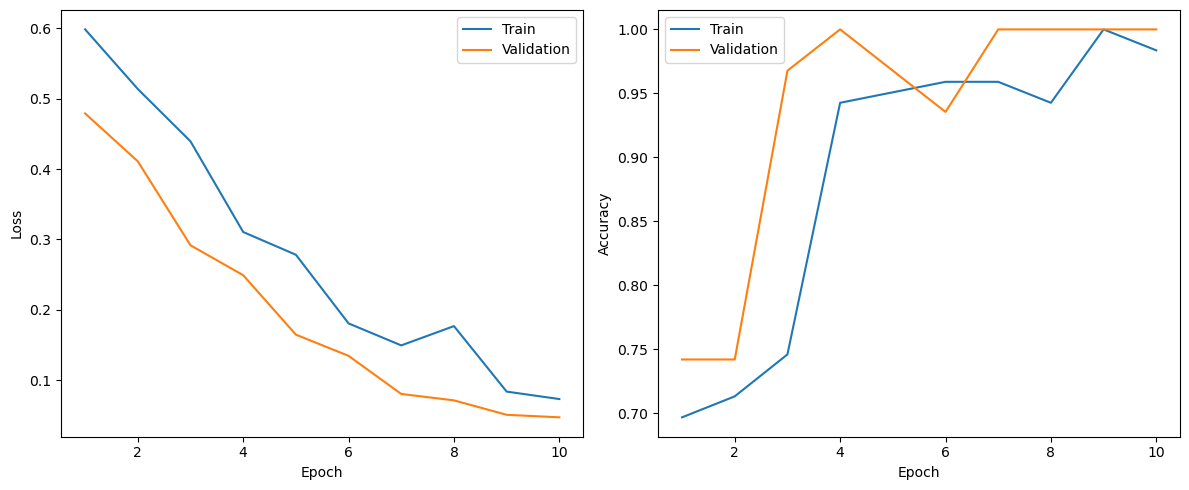

In [44]:
train_model(model, criterion, optimizer, num_epochs=10)

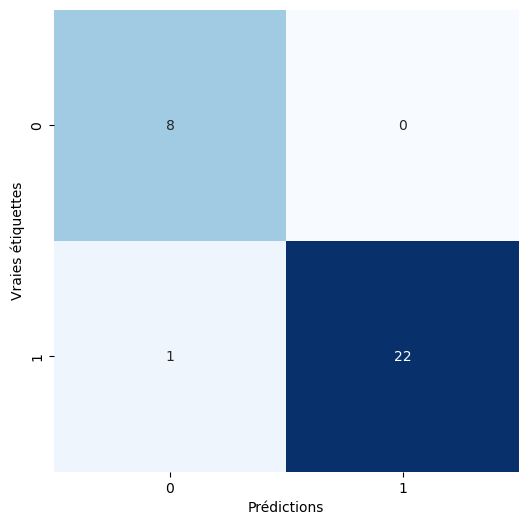

In [45]:
# Evaluate the model on the validation set
val_preds, val_labels = evaluate_model(model, val_dataloader)

# Display confusion matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Prédictions")
plt.ylabel("Vraies étiquettes")
plt.show()

### Save the trained model

In [46]:
torch.save(model.state_dict(), "resnet50_field_road.pth")

### Model test on test images

/Users/bahelhadj/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/bahelhadj/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


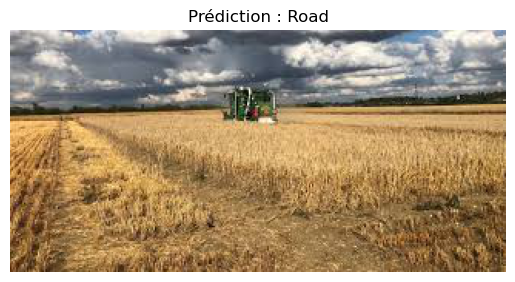

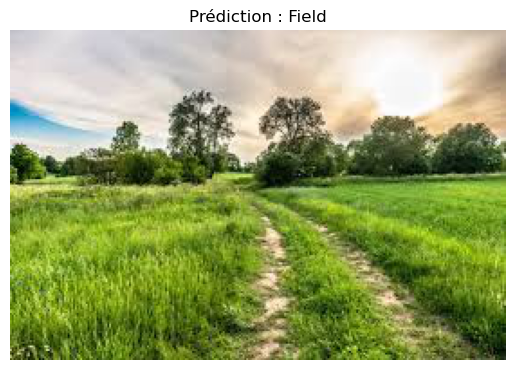

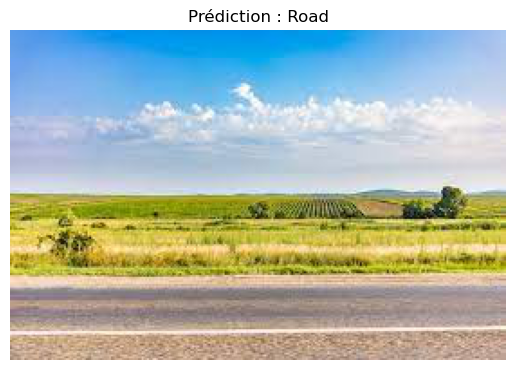

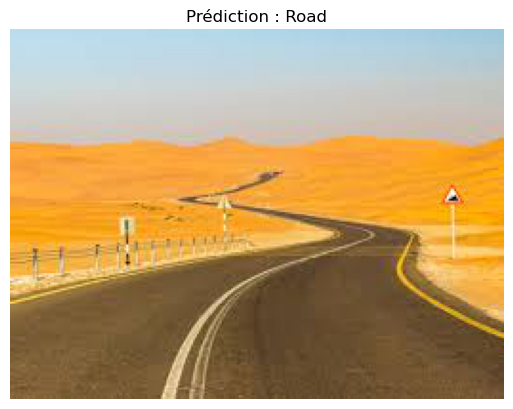

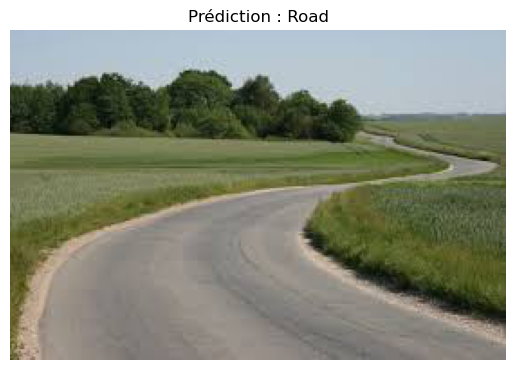

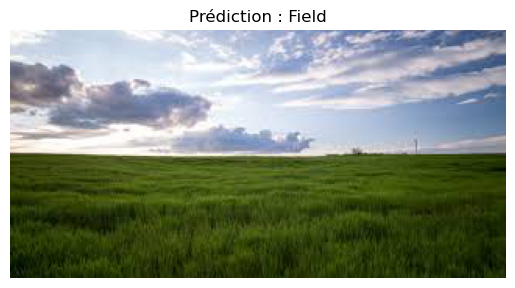

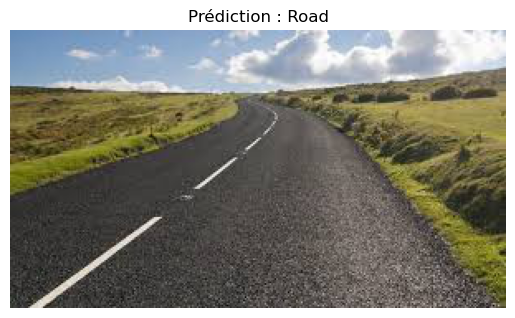

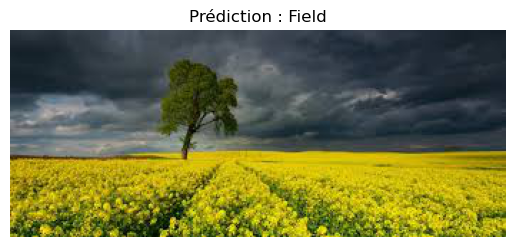

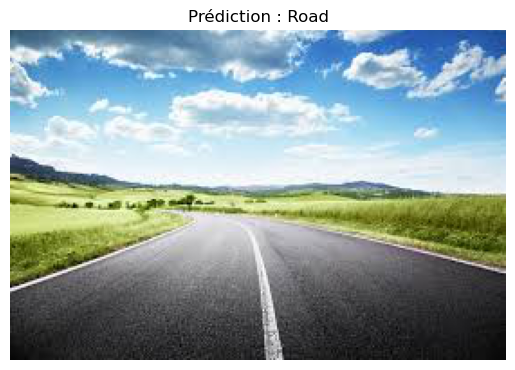

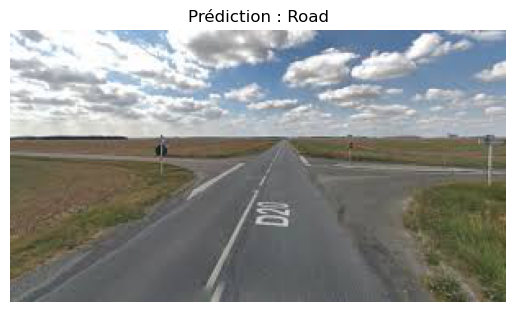

In [47]:
import os
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

# Define path to pre-trained model
model_path = "resnet50_field_road.pth"

# Set path for test images
test_dir = "/Users/bahelhadj/Downloads/dataset/test_images"

# Load the pre-trained model
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Replace last layer for 2 classes (Field & Road)
model.load_state_dict(torch.load(model_path))  # Load weights for trained model
model.eval()

# Define transformations to pre-process test images
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Load file names for test images
test_image_files = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if os.path.isfile(os.path.join(test_dir, f))]

# Defining classes (Field & Road)
classes = ['Field', 'Road']

# Evaluate the model on test images and display prediction results
for image_path in test_image_files:
    image = Image.open(image_path)
    inputs = data_transforms(image).unsqueeze(0).to(device)  # Ajouter une dimension batch (1, C, H, W)

    with torch.no_grad():
        outputs = model(inputs)
        _, pred_idx = torch.max(outputs, 1)
        pred_class = classes[pred_idx.item()]

    plt.imshow(image)
    plt.title(f"Prédiction : {pred_class}")
    plt.axis('off')
    plt.show()
